# Data Pre-processing


In [ ]:
import cv2,os

data_path='Dataset'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) 

print(label_dict)
print(categories)
print(labels)

{'without mask': 0, 'with mask': 1}
['without mask', 'with mask']
[0, 1]


In [ ]:
img_size=100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            resized=cv2.resize(gray,(img_size,img_size))
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)

In [ ]:
import numpy as np

data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

from keras.utils import np_utils

new_target=np_utils.to_categorical(target)

In [ ]:
np.save('data',data)
np.save('target',new_target)

# Training the CNN

In [ ]:
import numpy as np

data=np.load('data.npy')
target=np.load('target.npy')

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

model=Sequential()

model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50,activation='relu'))
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

In [ ]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=20,callbacks=[checkpoint],validation_split=0.2)

Epoch 1/20
32/32 [==============================] - 89s 3s/step - loss: 0.6613 - accuracy: 0.5936 - val_loss: 2.2974 - val_accuracy: 0.4819
INFO:tensorflow:Assets written to: model-001.model/assets
Epoch 2/20
32/32 [==============================] - 83s 3s/step - loss: 0.7679 - accuracy: 0.5423 - val_loss: 0.6378 - val_accuracy: 0.7590
INFO:tensorflow:Assets written to: model-002.model/assets
Epoch 3/20
32/32 [==============================] - 82s 3s/step - loss: 0.5285 - accuracy: 0.7394 - val_loss: 0.5909 - val_accuracy: 0.6747
INFO:tensorflow:Assets written to: model-003.model/assets
Epoch 4/20
32/32 [==============================] - 82s 3s/step - loss: 0.3085 - accuracy: 0.8803 - val_loss: 0.6994 - val_accuracy: 0.6827
Epoch 5/20
32/32 [==============================] - 82s 3s/step - loss: 0.2621 - accuracy: 0.8883 - val_loss: 0.2261 - val_accuracy: 0.9197
INFO:tensorflow:Assets written to: model-005.model/assets
Epoch 6/20
32/32 [==============================] - 82s 3s/step - lo

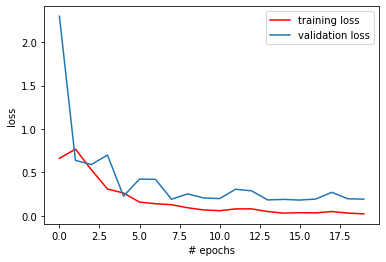

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

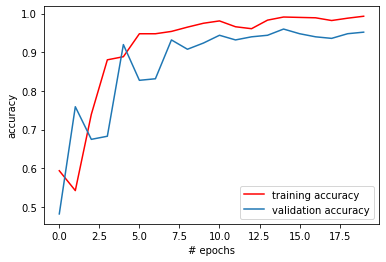

In [ ]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
print(model.evaluate(test_data,test_target))

5/5 [==============================] - 3s 549ms/step - loss: 0.1148 - accuracy: 0.9568
[0.11479998379945755, 0.9568345546722412]


# Mask Detection

In [ ]:
from keras.models import load_model
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
model = load_model('model-016.model')

face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

labels_dict={0:'MASK',1:'NO MASK'}
color_dict={0:(0,255,0),1:(0,0,255)}

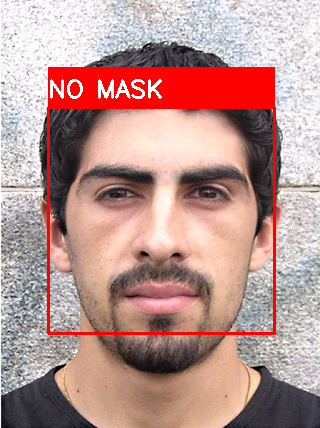

In [ ]:
img=cv2.imread('image')
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
faces=face_clsfr.detectMultiScale(gray,1.3,5)  

for (x,y,w,h) in faces:
    
    face_img=gray[y:y+w,x:x+w]
    resized=cv2.resize(face_img,(100,100))
    normalized=resized/255.0
    reshaped=np.reshape(normalized,(1,100,100,1))
    result=model.predict(reshaped)

    label=np.argmax(result,axis=1)[0]
      
    cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
    cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
    cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
cv2_imshow(img)
key=cv2.waitKey(0)